### Импорт библиотек, настройка



In [1]:
import torch
import os
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms
import matplotlib.pyplot as plt
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [2]:
print(f'PyTorch version: {torch.__version__}')
print('*'*10)
print(f'_CUDA version: ')
!nvcc --version
print('*'*10)
print(f'CUDNN version: {torch.backends.cudnn.version()}')
print(f'Available GPU devices: {torch.cuda.device_count()}')
print(f'Device Name: {torch.cuda.get_device_name()}')

PyTorch version: 2.2.1
**********
_CUDA version: 
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Tue_Feb_27_16:28:36_Pacific_Standard_Time_2024
Cuda compilation tools, release 12.4, V12.4.99
Build cuda_12.4.r12.4/compiler.33961263_0
**********
CUDNN version: 8801
Available GPU devices: 1
Device Name: NVIDIA GeForce GTX 1650 Ti


In [ ]:
# Распаковываем датасет с train/val/test
#!unzip '/content/drive/MyDrive/dataset_tubulitis/only_tubulitis/dataset.zip' -d '/content/drive/MyDrive/dataset_tubulitis/only_tubulitis/'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Create DataSet, Preproccesing, Augmentation, DataLoader


In [3]:
#Создаем класс для создания датасета, в котором используем аугментацию
#данных с помощью библиотеки Albumentation
class CustomDataset_AUG(Dataset):
    def __init__(self, img_path, msk_path, transform=None):
        self.images_paths = os.path.join(img_path, 'images')
        self.masks_paths = os.path.join(msk_path, 'masks')
        self.image_filenames = os.listdir(self.images_paths)
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_name = self.image_filenames[idx]
        image_path = os.path.join(self.images_paths, image_name)
        mask_path = os.path.join(self.masks_paths, image_name)


        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            augmented = self.transform(image=np.array(image), mask=np.array(mask))
            image = augmented['image']
            mask = augmented['mask']

        # Normalize images and masks
        image = transforms.ToTensor()(image)
        #image = transforms.Normalize(
        #    mean=[0.485, 0.456, 0.406],
        #    std=[0.229, 0.224, 0.225])
        mask = torch.from_numpy(np.array(mask, dtype=np.float32) / 255.0)

        return image, mask

In [6]:
# Распаковываем датасет для теста
!unzip '/content/drive/MyDrive/dataset_tubulitis/only_tubulitis/test.zip' -d '/content/drive/MyDrive/dataset_tubulitis/only_tubulitis/'

Archive:  /content/drive/MyDrive/dataset_tubulitis/only_tubulitis/test.zip
   creating: /content/drive/MyDrive/dataset_tubulitis/only_tubulitis/test/images/
  inflating: /content/drive/MyDrive/dataset_tubulitis/only_tubulitis/test/images/1002804 - 1 [x=10060,y=59667,w=512,h=512].png  
  inflating: /content/drive/MyDrive/dataset_tubulitis/only_tubulitis/test/images/1002804 - 1 [x=10121,y=58675,w=512,h=512].png  
  inflating: /content/drive/MyDrive/dataset_tubulitis/only_tubulitis/test/images/1002804 - 1 [x=10196,y=59302,w=512,h=512].png  
  inflating: /content/drive/MyDrive/dataset_tubulitis/only_tubulitis/test/images/1002804 - 1 [x=10202,y=60030,w=512,h=512].png  
  inflating: /content/drive/MyDrive/dataset_tubulitis/only_tubulitis/test/images/1002804 - 1 [x=10285,y=59410,w=512,h=512].png  
  inflating: /content/drive/MyDrive/dataset_tubulitis/only_tubulitis/test/images/1002804 - 1 [x=10404,y=59398,w=512,h=512].png  
  inflating: /content/drive/MyDrive/dataset_tubulitis/only_tubulitis/

In [5]:
# Пути данных
#DATA_DIR = "C:\\Users\\minik\\Desktop\\datasets\\dataset_tubulitis"
TRAIN_DATA = "C:\\Users\\minik\\Desktop\\datasets\\multiclass\\train"
VAL_DATA = "C:\\Users\\minik\\Desktop\\datasets\\multiclass\\val"
TEST_DATA = "C:\\Users\\minik\\Desktop\\datasets\\multiclass\\test"
#TRAIN_DATA_AUG = 'C:\\Users\\minik\\Desktop\\datasets\\dataset_tubulitis\\train_aug'
TEST = "C:\\Users\\minik\\Desktop\\datasets\\dataset_tubulitis\\train_aug"


In [7]:
#Задаем параменты аугментации
transform = A.Compose([
    A.OneOf([
            A.RandomRotate90(),
            A.Flip(),
            A.Transpose()
        ], p=0.3),
    A.OneOf([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=1),
        ], p=0.5),
    A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.CLAHE(p=0.8),
            A.RandomGamma(p=0.8)
        ], p=0.5),
    A.OneOf([
            A.MotionBlur(p=.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
            A.GaussNoise()
        ], p=0.2),
     A.OneOf([
            #A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
            A.GridDistortion(p=1)
        ], p=0.1)
])

In [8]:
# Создаем Augmented_DS
Augmented_DS = CustomDataset_AUG(
    img_path = TRAIN_DATA,
    msk_path = TRAIN_DATA,
    transform = transform
)

DIR_TO_AUG_IMAGE = "C:\\Users\\minik\\Desktop\\datasets\\multiclass\\train_aug\\images"
DIR_TO_AUG_MASK = "C:\\Users\\minik\\Desktop\\datasets\\multiclass\\train_aug\\masks"

num_augmentations = 3

for i in range(num_augmentations):

  for idx, (image, mask) in enumerate(Augmented_DS):
      # Convert tensor to numpy array
      image_np = image.permute(1, 2, 0).numpy()
      mask_np = mask.numpy()

      # Save augmented image and mask
      cv2.imwrite(
          os.path.join(DIR_TO_AUG_IMAGE, f"{idx}_{i}.png"),
          cv2.cvtColor((image_np * 255).astype(np.uint8),
          cv2.COLOR_RGB2BGR))
      cv2.imwrite(
          os.path.join(DIR_TO_AUG_MASK, f"{idx}_{i}.png"),
          (mask_np * 255).astype(np.uint8))

In [5]:
transform_set = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
            #transforms.Normalize(
            #    mean=[0.5],
            #    std=[0.5])
            ])

#Создаем класс для создания датасета, в котором используем аугментацию
#данных с помощью библиотеки Albumentation
class CustomDataset(Dataset):
    def __init__(self, img_path, msk_path, transform_set = transform_set):
        self.images_paths = os.path.join(img_path, 'images')
        self.masks_paths = os.path.join(msk_path, 'masks')
        self.image_filenames = os.listdir(self.images_paths)
        self.transform_set = transform_set


    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_name = self.image_filenames[idx]
        image_path = os.path.join(self.images_paths, image_name)
        mask_path = os.path.join(self.masks_paths, image_name)

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        # Normalize images and masks
        if self.transform_set:
            image = self.transform_set(image)
            mask = transforms.ToTensor()(mask)

        return image, mask

In [ ]:
# Создаем датасеты для обучения
from torch.utils.data import ConcatDataset


train_dataset = CustomDataset(
    img_path=TRAIN_DATA,
    msk_path=TRAIN_DATA,
    transform_set=transform_set
)

#Здесь мы используем обычную функцию, чтобы перевести изображение в тензоры
#и нормализровать его
#augmentation_train_dataset = CustomDataset(
#    img_path = TRAIN_DATA_AUG,
#    msk_path = TRAIN_DATA_AUG,
#    transform_set=transform_set
#)

#Формируем окончательный тренировочный датасет
#train_dataset = ConcatDataset(
#    [original_train_dataset, augmentation_train_dataset]
#)


val_dataset = CustomDataset(
    img_path=VAL_DATA,
    msk_path=VAL_DATA,
    transform_set=transform_set
)
test_dataset = CustomDataset(
    img_path=TEST_DATA,
    msk_path=TEST_DATA,
    transform_set=transform_set
)

testing = CustomDataset(
    img_path=TEST,
    msk_path=TEST,
    transform_set=transform_set
)


In [8]:
testing = CustomDataset(
    img_path=TEST,
    msk_path=TEST,
    transform_set=transform_set
)

testing_dataloader = DataLoader(testing, batch_size=4, shuffle=True)

In [11]:
# Создаем генераторы изображений для последовательной подачи в модель
# для тренировки, чтобы избежать ошибок с оперативной памятью и улучшить
# скорость обучения

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)


val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)


test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

testing_dataloader = DataLoader(testing, batch_size=16, shuffle=True)


In [9]:
img, lab = next(iter(testing_dataloader))
print(type(img))
print(img.shape)
print(lab.shape)


<class 'torch.Tensor'>
torch.Size([4, 3, 512, 512])
torch.Size([4, 1, 512, 512])


C:\Users\minik\AppData\Local\Temp\ipykernel_22056\292880808.py:5: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3641.)
  img = train_features[0].squeeze().T
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([4, 3, 512, 512])
Labels batch shape: torch.Size([4, 1, 512, 512])


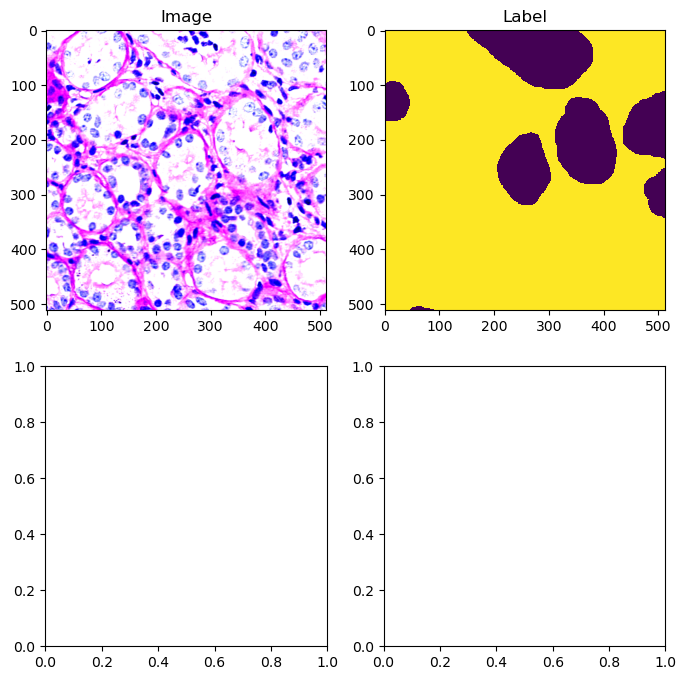

In [10]:
train_features, train_labels = next(iter(testing_dataloader))
figure, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,8))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze().T
label = train_labels[0]
ax[0, 0].imshow(img, cmap="gray")
ax[0, 0].set_title("Image")
ax[0, 1].set_title("Label")
ax[0, 1].imshow(label.T, interpolation="nearest")

### С этого момента неообходимо выбрать Архитектуру нейросети и произвести ее настройку


Семантическая бинарная сегментация

In [11]:
#!pip install -U segmentation-models-pytorch
#!pip install pytorch-lightning==1.9.3
import segmentation_models_pytorch as smp
import pytorch_lightning as pl


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
#!pip install tabulate

In [13]:
from tabulate import tabulate
from tqdm import tqdm
from collections import OrderedDict

In [ ]:
from tabulate import tabulate
from tqdm import tqdm
from collections import OrderedDict

class DroneModel(pl.LightningModule):
    def __init__(self, model, optimizer, criterion):
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer

    def forward(self, x):
        return self.model(x)

    def shared_step(self, batch, stage):
        image, mask = batch
        out = self.forward(image)
        loss = self.criterion(out, mask.long())
        tp, fp, fn, tn = smp.metrics.get_stats((out.sigmoid() > 0.5).long(), mask.long(), mode='binary')
        iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro-imagewise")
        recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro-imagewise")
        precision = smp.metrics.precision(tp, fp, fn, tn, reduction="micro-imagewise")
        self.log(f"{stage}_IoU", iou, prog_bar=True, on_epoch=True)
        self.log(f"{stage}_Accuracy", accuracy, prog_bar=True, on_epoch=True)
        self.log(f"{stage}_Recall", recall, prog_bar=True, on_epoch=True)
        self.log(f"{stage}_Precision", precision, prog_bar=True, on_epoch=True)
        self.log(f"{stage}_loss", loss)
        return {
            "loss": loss, "IoU": iou, "Accuracy": accuracy,
            "Recall": recall, "Precision": precision
            }

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def configure_optimizers(self):
        return self.optimizer

In [19]:
arch = 'unet'
enc_name = 'resnet50'
classes = 1

In [20]:


model = smp.create_model(arch,
                         encoder_name = enc_name,
                         encoder_weights = "imagenet",
                         in_channels = 3,
                         classes = classes).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-03)
criterion = criterion = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
cbs = pl.callbacks.ModelCheckpoint(dirpath = f'/content/drive/MyDrive/dataset_tubulitis/only_tubulitis/checkpoints/checkpoints_{arch}',
                                   filename = arch,
                                   verbose = True,
                                   monitor = 'valid_loss',
                                   mode = 'min')

In [ ]:
pl_model = DroneModel(model, optimizer, criterion)
trainer = pl.Trainer(max_epochs=10, auto_lr_find=True, gpus=1, callbacks=cbs)
trainer.fit(pl_model, train_dataloader, val_dataloader)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:474: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type     | Params
---------------------------------------
0 | model     | Unet     | 32.5 M
1 | criterion | DiceLoss | 0     
---------------------------------------
32.5 M    Trainable params
0         Non-trainable params
32.5 M 

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 362: 'valid_loss' reached 0.12011 (best 0.12011), saving model to '/content/drive/MyDrive/dataset_tubulitis/only_tubulitis/checkpoints/checkpoints_unet/unet.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 724: 'valid_loss' reached 0.11973 (best 0.11973), saving model to '/content/drive/MyDrive/dataset_tubulitis/only_tubulitis/checkpoints/checkpoints_unet/unet.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 1086: 'valid_loss' reached 0.11966 (best 0.11966), saving model to '/content/drive/MyDrive/dataset_tubulitis/only_tubulitis/checkpoints/checkpoints_unet/unet.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 1448: 'valid_loss' reached 0.11959 (best 0.11959), saving model to '/content/drive/MyDrive/dataset_tubulitis/only_tubulitis/checkpoints/checkpoints_unet/unet.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 1810: 'valid_loss' reached 0.11949 (best 0.11949), saving model to '/content/drive/MyDrive/dataset_tubulitis/only_tubulitis/checkpoints/checkpoints_unet/unet.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 2172: 'valid_loss' reached 0.11945 (best 0.11945), saving model to '/content/drive/MyDrive/dataset_tubulitis/only_tubulitis/checkpoints/checkpoints_unet/unet.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 2534: 'valid_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 2896: 'valid_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 3258: 'valid_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 3620: 'valid_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


### TESTING

In [ ]:
PATH_TO_SAVE = '/content/drive/MyDrive/dataset_tubulitis/only_tubulitis/checkpoints/ResNet50_10EP.pth'
torch.save(model.state_dict(), PATH_TO_SAVE)

In [14]:
model = torch.load('C:\\Users\\minik\\Desktop\\datasets\\Notebooks\\Det_Seg_Tubuli_RESNET50_10EP\\ResNet50_10EP.pth')

In [21]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-03)
criterion = criterion = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
cbs = pl.callbacks.ModelCheckpoint(dirpath = f'C:\\Users\\minik\\Desktop\\datasets\\Notebooks\\Det_Seg_Tubuli_RESNET50_10EP',
                                   filename = arch,
                                   verbose = True,
                                   monitor = 'valid_loss',
                                   mode = 'min')

In [22]:
cbs.best_model_path = 'C:\\Users\\minik\\Desktop\datasets\\Notebooks\\Det_Seg_Tubuli_RESNET50_10EP\\unet.ckpt'

In [ ]:
model = smp.create_model(arch,
                         encoder_name = enc_name,
                         encoder_weights = "imagenet",
                         in_channels = 3,
                         classes = classes).to(device)

state_dict = torch.load(cbs.best_model_path)['state_dict']
pl_state_dict = OrderedDict([(key[6:], state_dict[key]) for key in state_dict.keys()])

model.load_state_dict(pl_state_dict)
model.eval()

In [24]:


## TESTING
with torch.no_grad():

    outputs = []
    test_loss = 0.0
    iou = 0

    for image, mask in tqdm(testing_dataloader):

        image = image.to(device); mask = mask.to(device)
        output = model(image).to(device)
        tp, fp, fn, tn = smp.metrics.get_stats((output.sigmoid()>0.5).long(), mask.long(), mode='binary')

        outputs.append({"tp": tp, "fp": fp, "fn": fn, "tn": tn})
        loss = criterion(output, mask.long())
        test_loss += loss.item()

    tp = torch.cat([x["tp"] for x in outputs])
    fp = torch.cat([x["fp"] for x in outputs])
    fn = torch.cat([x["fn"] for x in outputs])
    tn = torch.cat([x["tn"] for x in outputs])

    print(f'Test Loss: {test_loss / len(testing_dataloader)}')
    print('IoU:', smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise").item())
    print('Accuracy:', smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro-imagewise").item())

100%|██████████| 1610/1610 [06:09<00:00,  4.36it/s]


NameError: name 'test_dataloader' is not defined

In [25]:
print(f'Test Loss: {test_loss / len(testing_dataloader)}')
print('IoU:', smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise").item())
print('Accuracy:', smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro-imagewise").item())

Test Loss: 0.18398112639877368
IoU: 0.6883735656738281
Accuracy: 0.7094131112098694


C:\Users\minik\AppData\Local\Temp\ipykernel_22056\2369161105.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = model(torch.tensor(image).unsqueeze(0).to(device))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input d

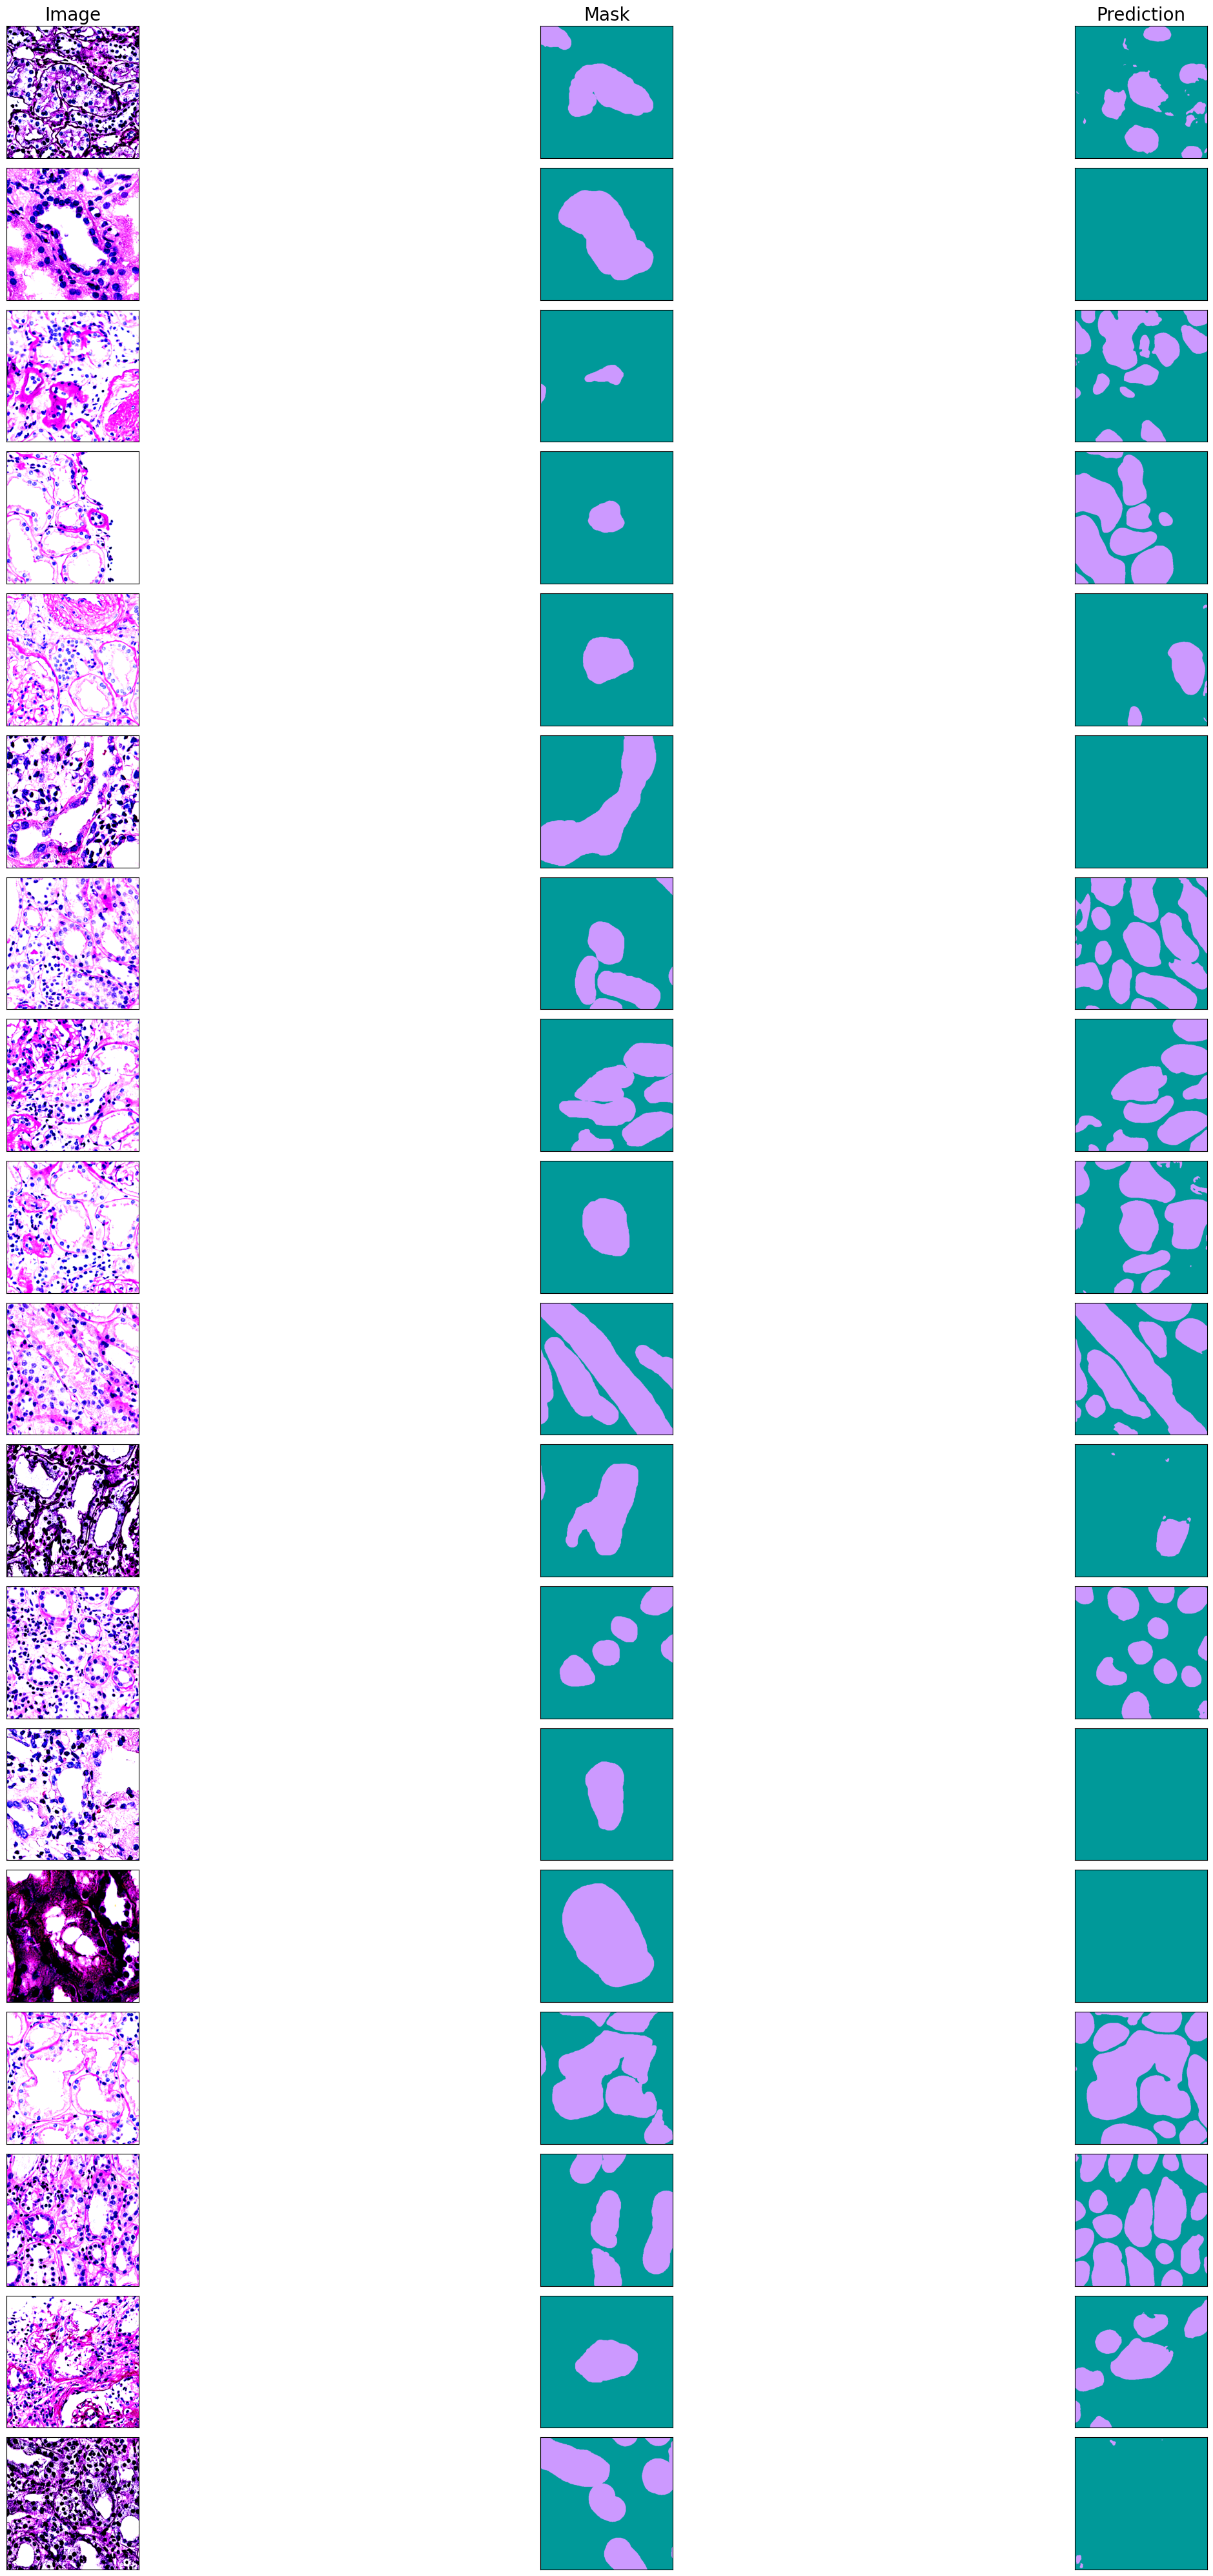

In [26]:
import random
random.seed(10)
samples = random.sample(range(len(testing_dataloader)), 18)

palette = [[204,153,255], [0,153,153]]
pal = [value for color in palette for value in color]

cols = ['Image', 'Mask', 'Prediction']
fig, axes = plt.subplots(len(samples), 3, figsize=(60, 40), sharex='row', sharey='row',
                         subplot_kw={'xticks':[], 'yticks':[]}, tight_layout=True)

for ax, col in zip(axes[0], cols): ax.set_title(col, fontsize=20) # set column label --> considered epoch

i=0

for i in range(len(samples)):

        image, mask = testing[samples[i]]
        pred = model(torch.tensor(image).unsqueeze(0).to(device))
        pred = (pred.sigmoid() > 0.5).long().squeeze(0)

        mask = Image.fromarray(mask.numpy().squeeze(0)).convert('L')
        pred = Image.fromarray(np.array(pred.squeeze(0).cpu()).astype('uint8')).convert('L')
        mask.putpalette(pal)
        pred.putpalette(pal)

        axes[i, 0].imshow(np.array(image).transpose(1, 2, 0), cmap='gray');
        axes[i, 1].imshow(mask);
        axes[i, 2].imshow(pred);

fig.savefig(arch + '.png')

In [27]:
metrics = np.round(torch.stack([torch.mean(smp.metrics.recall(tp, fp, fn, tn, reduction=None), 0),
                                torch.mean(smp.metrics.accuracy(tp, fp, fn, tn, reduction=None), 0),
                                torch.mean(smp.metrics.false_positive_rate(tp, fp, fn, tn, reduction=None), 0),
                                1 - torch.mean(smp.metrics.recall(tp, fp, fn, tn, reduction=None), 0),
                                torch.mean(smp.metrics.iou_score(tp, fp, fn, tn, reduction=None), 0),
                                torch.mean(smp.metrics.f1_score(tp, fp, fn, tn, reduction=None), 0)
                                ]).cpu().numpy(), 3)

info = {'Recall': metrics[0],
        'Accuracy':metrics[1],
        'FPR': metrics[2],
        'FNR': metrics[3],
        'IoU': metrics[4],
        'F1-Score': metrics[5]
        }

table = tabulate(info, headers='keys', tablefmt='fancy_grid')
print(table)

with open(f'{arch}.txt', 'w') as f:
    f.write(table)

╒══════════╤════════════╤═══════╤═══════╤═══════╤════════════╕
│   Recall │   Accuracy │   FPR │   FNR │   IoU │   F1-Score │
╞══════════╪════════════╪═══════╪═══════╪═══════╪════════════╡
│    0.839 │      0.709 │ 0.698 │ 0.161 │ 0.688 │      0.803 │
╘══════════╧════════════╧═══════╧═══════╧═══════╧════════════╛
